# Character level language model - Dinosaurus Island

Welcome to Dinosaurus Island! 65 million years ago, dinosaurs existed, and in this assignment they are back. You are in charge of a special task. Leading biology researchers are creating new breeds of dinosaurs and bringing them to life on earth, and your job is to give names to these dinosaurs. If a dinosaur does not like its name, it might go berserk, so choose wisely! 


Luckily you have learned some deep learning and you will use it to save the day. Your assistant has collected a list of all the dinosaur names they could find, and compiled them into this [dataset](dinos.txt). (Feel free to take a look by clicking the previous link.) To create new dinosaur names, you will build a character level language model to generate new names. Your algorithm will learn the different name patterns, and randomly generate new names. Hopefully this algorithm will keep you and your team safe from the dinosaurs' wrath! 

By completing this assignment you will learn:

- How to store text data for processing using an RNN 
- How to synthesize data, by sampling predictions at each time step and passing it to the next RNN-cell unit
- How to build a character-level text generation recurrent neural network
- Why clipping the gradients is important

We will begin by loading in some functions that we have provided for you in `rnn_utils`. Specifically, you have access to functions such as `rnn_forward` and `rnn_backward` which are equivalent to those you've implemented in the previous assignment. 

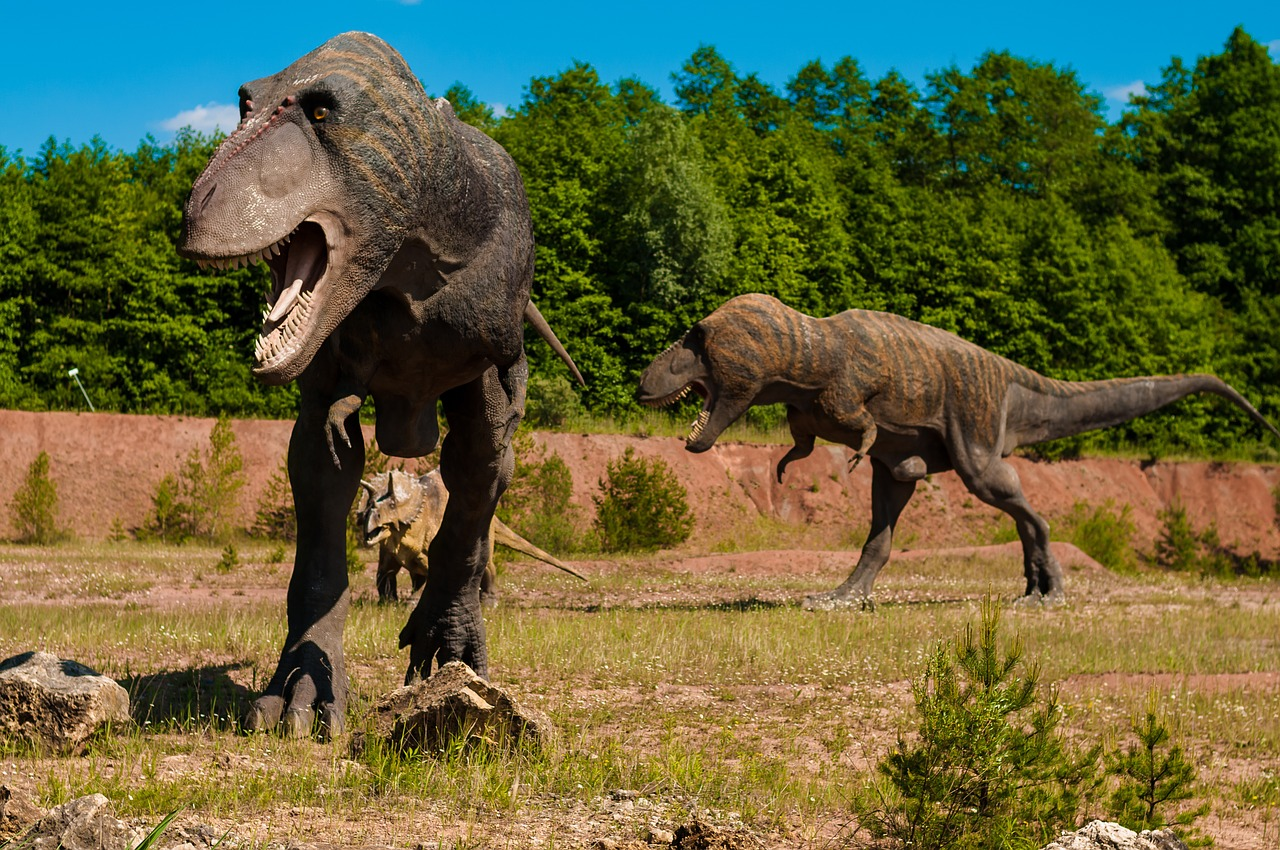

## <font color='DeepSkyBlue'>Updates</font>

#### If you were working on the notebook before this update...
* The current notebook is version "3a".
* You can find your original work saved in the notebook with the previous version name ("v3") 
* To view the file directory, go to the menu "File->Open", and this will open a new tab that shows the file directory.

#### List of updates
* Sort and print `chars` list of characters.
* Import and use pretty print
* `clip`: 
    - Additional details on why we need to use the "out" parameter.
    - Modified for loop to have students fill in the correct items to loop through.
    - Added a test case to check for hard-coding error.
* `sample`
    - additional hints added to steps 1,2,3,4.
    - "Using 2D arrays instead of 1D arrays".
    - explanation of numpy.ravel().
    - fixed expected output.
    - clarified comments in the code.
* "training the model"
    - Replaced the sample code with explanations for how to set the index, X and Y (for a better learning experience).
* Spelling, grammar and wording corrections.

In [1]:
import numpy as np
from utils import *
import random
import pprint

## 1 - Problem Statement

### 1.1 - Dataset and Preprocessing

Run the following cell to read the dataset of dinosaur names, create a list of unique characters (such as a-z), and compute the dataset and vocabulary size. 

In [2]:
data = open('dinos.txt', 'r').read()
data= data.lower()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

There are 19909 total characters and 27 unique characters in your data.



* The characters are a-z (26 characters) plus the "\n" (or newline character).
* In this assignment, the newline character "\n" plays a role similar to the `<EOS>` (or "End of sentence") token we had discussed in lecture.  
    - Here, "\n" indicates the end of the dinosaur name rather than the end of a sentence. 
* `char_to_ix`: In the cell below, we create a python dictionary (i.e., a hash table) to map each character to an index from 0-26.
* `ix_to_char`: We also create a second python dictionary that maps each index back to the corresponding character. 
    -  This will help you figure out what index corresponds to what character in the probability distribution output of the softmax layer. 

In [3]:
chars = sorted(chars)
print(chars)

['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(ix_to_char)

{   0: '\n',
    1: 'a',
    2: 'b',
    3: 'c',
    4: 'd',
    5: 'e',
    6: 'f',
    7: 'g',
    8: 'h',
    9: 'i',
    10: 'j',
    11: 'k',
    12: 'l',
    13: 'm',
    14: 'n',
    15: 'o',
    16: 'p',
    17: 'q',
    18: 'r',
    19: 's',
    20: 't',
    21: 'u',
    22: 'v',
    23: 'w',
    24: 'x',
    25: 'y',
    26: 'z'}


### 1.2 - Overview of the model

Your model will have the following structure: 

- Initialize parameters 
- Run the optimization loop
    - Forward propagation to compute the loss function
    - Backward propagation to compute the gradients with respect to the loss function
    - Clip the gradients to avoid exploding gradients
    - Using the gradients, update your parameters with the gradient descent update rule.
- Return the learned parameters 

* At each time-step, the RNN tries to predict what is the next character given the previous characters. 
* The dataset $\mathbf{X} = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a list of characters in the training set.
* $\mathbf{Y} = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$ is the same list of characters but shifted one character forward. 
* At every time-step $t$, $y^{\langle t \rangle} = x^{\langle t+1 \rangle}$.  The prediction at time $t$ is the same as the input at time $t + 1$.

## 2 - Building blocks of the model

In this part, you will build two important blocks of the overall model:
- Gradient clipping: to avoid exploding gradients
- Sampling: a technique used to generate characters

You will then apply these two functions to build the model.

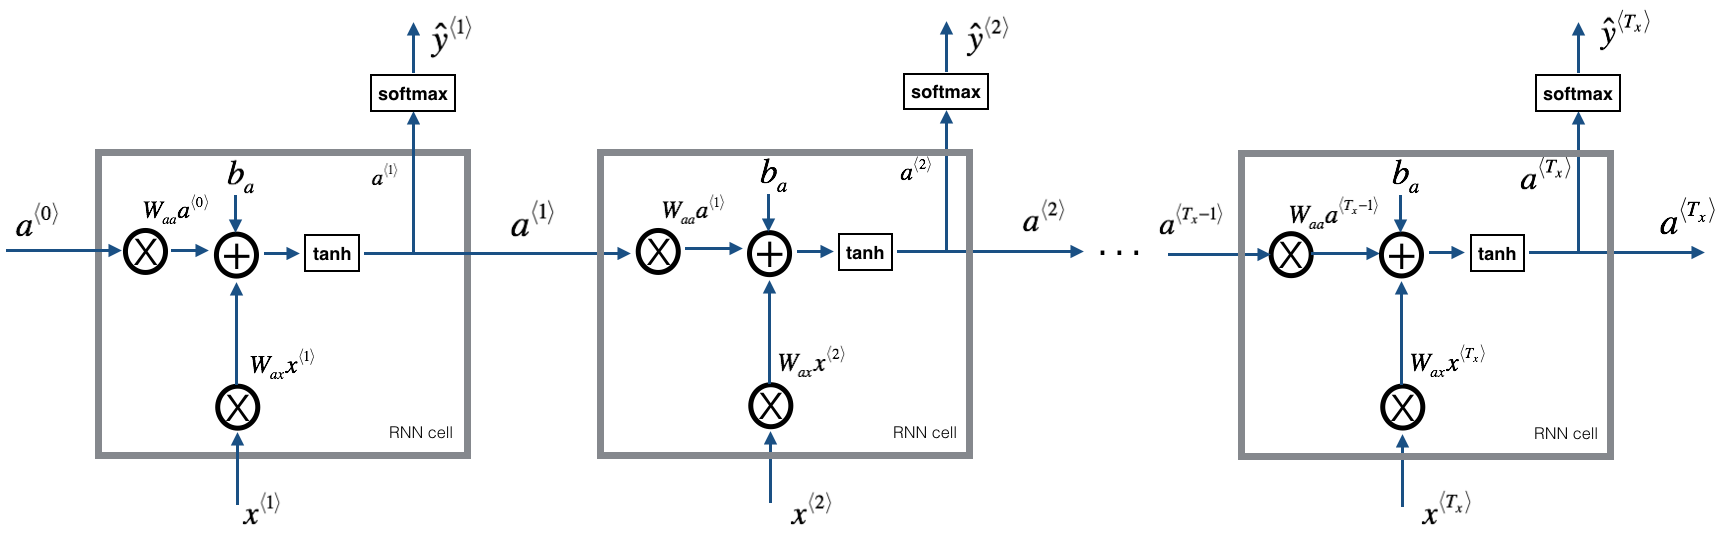

### 2.1 - Clipping the gradients in the optimization loop

In this section you will implement the `clip` function that you will call inside of your optimization loop. 

#### Exploding gradients
* When gradients are very large, they're called "exploding gradients."  
* Exploding gradients make the training process more difficult, because the updates may be so large that they "overshoot" the optimal values during back propagation.

Recall that your overall loop structure usually consists of:
* forward pass, 
* cost computation, 
* backward pass, 
* parameter update. 

Before updating the parameters, you will perform gradient clipping to make sure that your gradients are not "exploding."

#### gradient clipping
In the exercise below, you will implement a function `clip` that takes in a dictionary of gradients and returns a clipped version of gradients if needed. 
* There are different ways to clip gradients.
* We will use a simple element-wise clipping procedure, in which every element of the gradient vector is clipped to lie between some range [-N, N]. 
* For example, if the N=10
    - The range is [-10, 10]
    - If any component of the gradient vector is greater than 10, it is set to 10.
    - If any component of the gradient vector is less than -10, it is set to -10. 
    - If any components are between -10 and 10, they keep their original values.

<img src="images/clip.png" style="width:400;height:150px;">
<caption><center> **Figure 2**: Visualization of gradient descent with and without gradient clipping, in a case where the network is running into "exploding gradient" problems. </center></caption>

**Exercise**: 
Implement the function below to return the clipped gradients of your dictionary `gradients`. 
* Your function takes in a maximum threshold and returns the clipped versions of the gradients. 
* You can check out [numpy.clip](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.clip.html). 
    - You will need to use the argument "`out = ...`".
    - Using the "`out`" parameter allows you to update a variable "in-place".
    - If you don't use "`out`" argument, the clipped variable is stored in the variable "gradient" but does not update the gradient variables `dWax`, `dWaa`, `dWya`, `db`, `dby`.

In [5]:
### GRADED FUNCTION: clip

def clip(gradients, maxValue):
    '''
    Clips the gradients' values between minimum and maximum.
    
    Arguments:
    gradients -- a dictionary containing the gradients "dWaa", "dWax", "dWya", "db", "dby"
    maxValue -- everything above this number is set to this number, and everything less than -maxValue is set to -maxValue
    
    Returns: 
    gradients -- a dictionary with the clipped gradients.
    '''
    
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
   
    ### START CODE HERE ###
    # clip to mitigate exploding gradients, loop over [dWax, dWaa, dWya, db, dby]. (≈2 lines)
    for gradient in [dWaa, dWax, dWya, db, dby]:
        np.clip(gradient, -maxValue, maxValue, out=gradient)
    ### END CODE HERE ###
    
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients

In [6]:
# Test with a maxvalue of 10
maxValue = 10
np.random.seed(3)
dWax = np.random.randn(5,3)*10
dWaa = np.random.randn(5,5)*10
dWya = np.random.randn(2,5)*10
db = np.random.randn(5,1)*10
dby = np.random.randn(2,1)*10
gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "db": db, "dby": dby}
gradients = clip(gradients, maxValue)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])

gradients["dWaa"][1][2] = 10.0
gradients["dWax"][3][1] = -10.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [10.]
gradients["dby"][1] = [8.45833407]


** Expected output:**

```Python
gradients["dWaa"][1][2] = 10.0
gradients["dWax"][3][1] = -10.0
gradients["dWya"][1][2] = 0.29713815361
gradients["db"][4] = [ 10.]
gradients["dby"][1] = [ 8.45833407]
```

In [7]:
# Test with a maxValue of 5
maxValue = 5
np.random.seed(3)
dWax = np.random.randn(5,3)*10
dWaa = np.random.randn(5,5)*10
dWya = np.random.randn(2,5)*10
db = np.random.randn(5,1)*10
dby = np.random.randn(2,1)*10
gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "db": db, "dby": dby}
gradients = clip(gradients, maxValue)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])

gradients["dWaa"][1][2] = 5.0
gradients["dWax"][3][1] = -5.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [5.]
gradients["dby"][1] = [5.]


** Expected Output: **
```Python
gradients["dWaa"][1][2] = 5.0
gradients["dWax"][3][1] = -5.0
gradients["dWya"][1][2] = 0.29713815361
gradients["db"][4] = [ 5.]
gradients["dby"][1] = [ 5.]
```

### 2.2 - Sampling

Now assume that your model is trained. You would like to generate new text (characters). The process of generation is explained in the picture below:

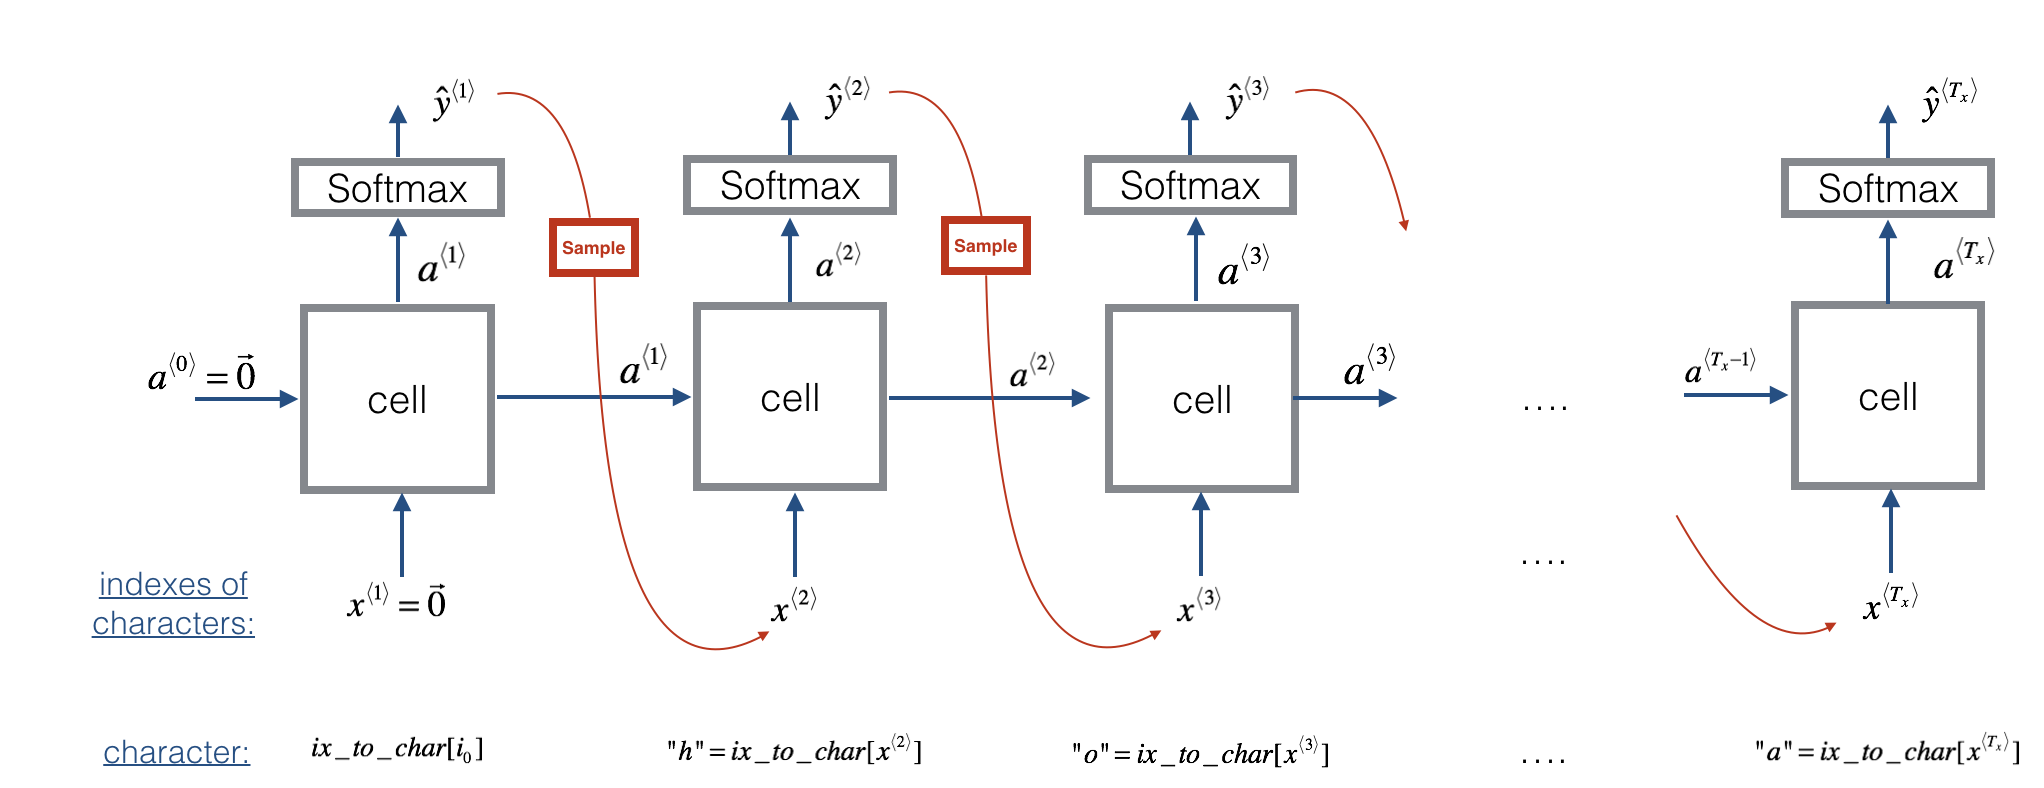

**Exercise**: Implement the `sample` function below to sample characters. You need to carry out 4 steps:

- **Step 1**: Input the "dummy" vector of zeros $x^{\langle 1 \rangle} = \vec{0}$. 
    - This is the default input before we've generated any characters. 
    We also set $a^{\langle 0 \rangle} = \vec{0}$

- **Step 2**: Run one step of forward propagation to get $a^{\langle 1 \rangle}$ and $\hat{y}^{\langle 1 \rangle}$. Here are the equations:

hidden state:  
$$ a^{\langle t+1 \rangle} = \tanh(W_{ax}  x^{\langle t+1 \rangle } + W_{aa} a^{\langle t \rangle } + b)\tag{1}$$

activation:
$$ z^{\langle t + 1 \rangle } = W_{ya}  a^{\langle t + 1 \rangle } + b_y \tag{2}$$

prediction:
$$ \hat{y}^{\langle t+1 \rangle } = softmax(z^{\langle t + 1 \rangle })\tag{3}$$

- Details about $\hat{y}^{\langle t+1 \rangle }$:
   - Note that $\hat{y}^{\langle t+1 \rangle }$ is a (softmax) probability vector (its entries are between 0 and 1 and sum to 1). 
   - $\hat{y}^{\langle t+1 \rangle}_i$ represents the probability that the character indexed by "i" is the next character.  
   - We have provided a `softmax()` function that you can use.

#### Additional Hints

- $x^{\langle 1 \rangle}$ is `x` in the code. When creating the one-hot vector, make a numpy array of zeros, with the number of rows equal to the number of unique characters, and the number of columns equal to one.  It's a 2D and not a 1D array.
- $a^{\langle 0 \rangle}$ is `a_prev` in the code.  It is a numpy array of zeros, where the number of rows is $n_{a}$, and number of columns is 1.  It is a 2D array as well.  $n_{a}$ is retrieved by getting the number of columns in $W_{aa}$ (the numbers need to match in order for the matrix multiplication $W_{aa}a^{\langle t \rangle}$ to work.
- [numpy.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html)
- [numpy.tanh](https://docs.scipy.org/doc/numpy/reference/generated/numpy.tanh.html)

#### Using 2D arrays instead of 1D arrays
* You may be wondering why we emphasize that $x^{\langle 1 \rangle}$ and $a^{\langle 0 \rangle}$ are 2D arrays and not 1D vectors.
* For matrix multiplication in numpy, if we multiply a 2D matrix with a 1D vector, we end up with with a 1D array.
* This becomes a problem when we add two arrays where we expected them to have the same shape.
* When two arrays with  a different number of dimensions are added together, Python "broadcasts" one across the other.
* Here is some sample code that shows the difference between using a 1D and 2D array.

In [8]:
import numpy as np

In [9]:
matrix1 = np.array([[1,1],[2,2],[3,3]]) # (3,2)
matrix2 = np.array([[0],[0],[0]]) # (3,1) 
vector1D = np.array([1,1]) # (2,) 
vector2D = np.array([[1],[1]]) # (2,1)
print("matrix1 \n", matrix1,"\n")
print("matrix2 \n", matrix2,"\n")
print("vector1D \n", vector1D,"\n")
print("vector2D \n", vector2D)

matrix1 
 [[1 1]
 [2 2]
 [3 3]] 

matrix2 
 [[0]
 [0]
 [0]] 

vector1D 
 [1 1] 

vector2D 
 [[1]
 [1]]


In [10]:
print("Multiply 2D and 1D arrays: result is a 1D array\n", 
      np.dot(matrix1,vector1D))
print("Multiply 2D and 2D arrays: result is a 2D array\n", 
      np.dot(matrix1,vector2D))

Multiply 2D and 1D arrays: result is a 1D array
 [2 4 6]
Multiply 2D and 2D arrays: result is a 2D array
 [[2]
 [4]
 [6]]


In [11]:
print("Adding (3 x 1) vector to a (3 x 1) vector is a (3 x 1) vector\n",
      "This is what we want here!\n", 
      np.dot(matrix1,vector2D) + matrix2)

Adding (3 x 1) vector to a (3 x 1) vector is a (3 x 1) vector
 This is what we want here!
 [[2]
 [4]
 [6]]


In [12]:
print("Adding a (3,) vector to a (3 x 1) vector\n",
      "broadcasts the 1D array across the second dimension\n",
      "Not what we want here!\n",
      np.dot(matrix1,vector1D) + matrix2
     )

Adding a (3,) vector to a (3 x 1) vector
 broadcasts the 1D array across the second dimension
 Not what we want here!
 [[2 4 6]
 [2 4 6]
 [2 4 6]]


- **Step 3**: Sampling: 
    - Now that we have $y^{\langle t+1 \rangle}$, we want to select the next letter in the dinosaur name. If we select the most probable, the model will always generate the same result given a starting letter. 
        - To make the results more interesting, we will use np.random.choice to select a next letter that is likely, but not always the same.
    - Sampling is the selection of a value from a group of values, where each value has a probability of being picked.  
    - Sampling allows us to generate random sequences of values.
    - Pick the next character's index according to the probability distribution specified by $\hat{y}^{\langle t+1 \rangle }$. 
    - This means that if $\hat{y}^{\langle t+1 \rangle }_i = 0.16$, you will pick the index "i" with 16% probability. 
    - You can use [np.random.choice](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.choice.html).

    Example of how to use `np.random.choice()`:
    ```python
    np.random.seed(0)
    probs = np.array([0.1, 0.0, 0.7, 0.2])
    idx = np.random.choice([0, 1, 2, 3] p = probs)
    ```
    - This means that you will pick the index (`idx`) according to the distribution: 

    $P(index = 0) = 0.1, P(index = 1) = 0.0, P(index = 2) = 0.7, P(index = 3) = 0.2$.

    - Note that the value that's set to `p` should be set to a 1D vector.
    - Also notice that $\hat{y}^{\langle t+1 \rangle}$, which is `y` in the code, is a 2D array.

##### Additional Hints
- [range](https://docs.python.org/3/library/functions.html#func-range)
- [numpy.ravel](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html) takes a multi-dimensional array and returns its contents inside of a 1D vector.
```Python
arr = np.array([[1,2],[3,4]])
print("arr")
print(arr)
print("arr.ravel()")
print(arr.ravel())
```
Output:
```Python
arr
[[1 2]
 [3 4]]
arr.ravel()
[1 2 3 4]
```

- Note that `append` is an "in-place" operation.  In other words, don't do this:
```Python
fun_hobbies = fun_hobbies.append('learning')  ## Doesn't give you what you want
```

- **Step 4**: Update to $x^{\langle t \rangle }$ 
    - The last step to implement in `sample()` is to update the variable `x`, which currently stores $x^{\langle t \rangle }$, with the value of $x^{\langle t + 1 \rangle }$. 
    - You will represent $x^{\langle t + 1 \rangle }$ by creating a one-hot vector corresponding to the character that you have chosen as your prediction. 
    - You will then forward propagate $x^{\langle t + 1 \rangle }$ in Step 1 and keep repeating the process until you get a "\n" character, indicating that you have reached the end of the dinosaur name. 

##### Additional Hints
- In order to reset `x` before setting it to the new one-hot vector, you'll want to set all the values to zero.
    - You can either create a new numpy array: [numpy.zeros](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html)
    - Or fill all values with a single number: [numpy.ndarray.fill](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.fill.html)

In [13]:
# GRADED FUNCTION: sample

def sample(parameters, char_to_ix, seed):
    """
    Sample a sequence of characters according to a sequence of probability distributions output of the RNN

    Arguments:
    parameters -- python dictionary containing the parameters Waa, Wax, Wya, by, and b. 
    char_to_ix -- python dictionary mapping each character to an index.
    seed -- used for grading purposes. Do not worry about it.

    Returns:
    indices -- a list of length n containing the indices of the sampled characters.
    """
    
    # Retrieve parameters and relevant shapes from "parameters" dictionary
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]
    
    ### START CODE HERE ###
    # Step 1: Create the a zero vector x that can be used as the one-hot vector 
    # representing the first character (initializing the sequence generation). (≈1 line)
    x = np.zeros((vocab_size,1))
    # Step 1': Initialize a_prev as zeros (≈1 line)
    a_prev = np.zeros((n_a, 1))
    
    # Create an empty list of indices, this is the list which will contain the list of indices of the characters to generate (≈1 line)
    indices = []
    
    # idx is the index of the one-hot vector x that is set to 1
    # All other positions in x are zero.
    # We will initialize idx to -1
    idx = -1
    
    # Loop over time-steps t. At each time-step:
    # sample a character from a probability distribution 
    # and append its index (`idx`) to the list "indices". 
    # We'll stop if we reach 50 characters 
    # (which should be very unlikely with a well trained model).
    # Setting the maximum number of characters helps with debugging and prevents infinite loops. 
    counter = 0
    newline_character = char_to_ix['\n']
    
    while (idx != newline_character and counter != 50):
        
        # Step 2: Forward propagate x using the equations (1), (2) and (3)
        a = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b)
        z = np.dot(Wya, a) + by
        y = softmax(z)
        # for grading purposes
        np.random.seed(counter+seed)
        
        # Step 3: Sample the index of a character within the vocabulary from the probability distribution y
        # (see additional hints above)        
        idx = np.random.choice(list(range(vocab_size)), p=y.ravel())

        # Append the index to "indices"
        indices.append(idx)
        
        # Step 4: Overwrite the input character as the one corresponding to the sampled index.
        x = np.zeros((vocab_size, 1))
        x[idx] = 1
        # Update "a_prev" to be "a"
        a_prev = a
        
        # for grading purposes
        seed += 1
        counter +=1      
        
    ### END CODE HERE ###

    if (counter == 50):
        indices.append(char_to_ix['\n'])
    
    return indices

In [14]:
np.random.seed(2)
_, n_a = 20, 100
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}


indices = sample(parameters, char_to_ix, 0)
print("Sampling:")
print("list of sampled indices:\n", indices)
print("list of sampled characters:\n", [ix_to_char[i] for i in indices])

Sampling:
list of sampled indices:
 [12, 17, 24, 14, 13, 9, 10, 22, 24, 6, 13, 11, 12, 6, 21, 15, 21, 14, 3, 2, 1, 21, 18, 24, 7, 25, 6, 25, 18, 10, 16, 2, 3, 8, 15, 12, 11, 7, 1, 12, 10, 2, 7, 7, 11, 5, 6, 5, 3, 0, 0]
list of sampled characters:
 ['l', 'q', 'x', 'n', 'm', 'i', 'j', 'v', 'x', 'f', 'm', 'k', 'l', 'f', 'u', 'o', 'u', 'n', 'c', 'b', 'a', 'u', 'r', 'x', 'g', 'y', 'f', 'y', 'r', 'j', 'p', 'b', 'c', 'h', 'o', 'l', 'k', 'g', 'a', 'l', 'j', 'b', 'g', 'g', 'k', 'e', 'f', 'e', 'c', '\n', '\n']


** Expected output:**

```Python
Sampling:
list of sampled indices:
 [12, 17, 24, 14, 13, 9, 10, 22, 24, 6, 13, 11, 12, 6, 21, 15, 21, 14, 3, 2, 1, 21, 18, 24, 7, 25, 6, 25, 18, 10, 16, 2, 3, 8, 15, 12, 11, 7, 1, 12, 10, 2, 7, 7, 11, 17, 24, 12, 13, 24, 0]
list of sampled characters:
 ['l', 'q', 'x', 'n', 'm', 'i', 'j', 'v', 'x', 'f', 'm', 'k', 'l', 'f', 'u', 'o', 'u', 'n', 'c', 'b', 'a', 'u', 'r', 'x', 'g', 'y', 'f', 'y', 'r', 'j', 'p', 'b', 'c', 'h', 'o', 'l', 'k', 'g', 'a', 'l', 'j', 'b', 'g', 'g', 'k', 'q', 'x', 'l', 'm', 'x', '\n']
```

* Please note that over time, if there are updates to the back-end of the Coursera platform (that may update the version of numpy), the actual list of sampled indices and sampled characters may change. 
* If you follow the instructions given above and get an output without errors, it's possible the routine is correct even if your output doesn't match the expected output.  Submit your assignment to the grader to verify its correctness.

## 3 - Building the language model 

It is time to build the character-level language model for text generation. 


### 3.1 - Gradient descent 

* In this section you will implement a function performing one step of stochastic gradient descent (with clipped gradients). 
* You will go through the training examples one at a time, so the optimization algorithm will be stochastic gradient descent. 

As a reminder, here are the steps of a common optimization loop for an RNN:

- Forward propagate through the RNN to compute the loss
- Backward propagate through time to compute the gradients of the loss with respect to the parameters
- Clip the gradients
- Update the parameters using gradient descent 

**Exercise**: Implement the optimization process (one step of stochastic gradient descent). 

The following functions are provided:

```python
def rnn_forward(X, Y, a_prev, parameters):
    """ Performs the forward propagation through the RNN and computes the cross-entropy loss.
    It returns the loss' value as well as a "cache" storing values to be used in backpropagation."""
    ....
    return loss, cache
    
def rnn_backward(X, Y, parameters, cache):
    """ Performs the backward propagation through time to compute the gradients of the loss with respect
    to the parameters. It returns also all the hidden states."""
    ...
    return gradients, a

def update_parameters(parameters, gradients, learning_rate):
    """ Updates parameters using the Gradient Descent Update Rule."""
    ...
    return parameters
```

Recall that you previously implemented the `clip` function:

```Python
def clip(gradients, maxValue)
    """Clips the gradients' values between minimum and maximum."""
    ...
    return gradients
```

#### parameters

* Note that the weights and biases inside the `parameters` dictionary are being updated by the optimization, even though `parameters` is not one of the returned values of the `optimize` function. The `parameters` dictionary is passed by reference into the function, so changes to this dictionary are making changes to the `parameters` dictionary even when accessed outside of the function.
* Python dictionaries and lists are "pass by reference", which means that if you pass a dictionary into a function and modify the dictionary within the function, this changes that same dictionary (it's not a copy of the dictionary).

In [15]:
# GRADED FUNCTION: optimize

def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    """
    Execute one step of the optimization to train the model.
    
    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    learning_rate -- learning rate for the model.
    
    Returns:
    loss -- value of the loss function (cross-entropy)
    gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    """
    
    ### START CODE HERE ###
    
    # Forward propagate through time (≈1 line)
    loss, cache = rnn_forward(X, Y, a_prev, parameters)
    
    # Backpropagate through time (≈1 line)
    gradients, a = rnn_backward(X, Y, parameters, cache)
    
    # Clip your gradients between -5 (min) and 5 (max) (≈1 line)
    gradients = clip(gradients, maxValue)
    
    # Update parameters (≈1 line)
    parameters = update_parameters(parameters, gradients, learning_rate)
    
    ### END CODE HERE ###
    
    return loss, gradients, a[len(X)-1]

In [16]:
np.random.seed(1)
vocab_size, n_a = 27, 100
a_prev = np.random.randn(n_a, 1)
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}
X = [12,3,5,11,22,3]
Y = [4,14,11,22,25, 26]

loss, gradients, a_last = optimize(X, Y, a_prev, parameters, learning_rate = 0.01)
print("Loss =", loss)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("np.argmax(gradients[\"dWax\"]) =", np.argmax(gradients["dWax"]))
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])
print("a_last[4] =", a_last[4])

Loss = 126.50397572165363
gradients["dWaa"][1][2] = 0.19470931534722233
np.argmax(gradients["dWax"]) = 93
gradients["dWya"][1][2] = -0.0077738760320040625
gradients["db"][4] = [-0.06809825]
gradients["dby"][1] = [0.01538192]
a_last[4] = [-1.]


** Expected output:**

```Python
Loss = 126.503975722
gradients["dWaa"][1][2] = 0.194709315347
np.argmax(gradients["dWax"]) = 93
gradients["dWya"][1][2] = -0.007773876032
gradients["db"][4] = [-0.06809825]
gradients["dby"][1] = [ 0.01538192]
a_last[4] = [-1.]
```

### 3.2 - Training the model 

* Given the dataset of dinosaur names, we use each line of the dataset (one name) as one training example. 
* Every 100 steps of stochastic gradient descent, you will sample 10 randomly chosen names to see how the algorithm is doing. 
* Remember to shuffle the dataset, so that stochastic gradient descent visits the examples in random order. 

**Exercise**: Follow the instructions and implement `model()`. When `examples[index]` contains one dinosaur name (string), to create an example (X, Y), you can use this:

##### Set the index `idx` into the list of examples
* Using the for-loop, walk through the shuffled list of dinosaur names in the list "examples".
* If there are 100 examples, and the for-loop increments the index to 100 onwards, think of how you would make the index cycle back to 0, so that we can continue feeding the examples into the model when j is 100, 101, etc.
* Hint: 101 divided by 100 is zero with a remainder of 1.
* `%` is the modulus operator in python.

##### Extract a single example from the list of examples
* `single_example`: use the `idx` index that you set previously to get one word from the list of examples.

##### Convert a string into a list of characters: `single_example_chars`
* `single_example_chars`: A string is a list of characters.
* You can use a list comprehension (recommended over for-loops) to generate a list of characters.
```Python
str = 'I love learning'
list_of_chars = [c for c in str]
print(list_of_chars)
```

```
['I', ' ', 'l', 'o', 'v', 'e', ' ', 'l', 'e', 'a', 'r', 'n', 'i', 'n', 'g']
```

##### Convert list of characters to a list of integers: `single_example_ix`
* Create a list that contains the index numbers associated with each character.
* Use the dictionary `char_to_ix`
* You can combine this with the list comprehension that is used to get a list of characters from a string.
* This is a separate line of code below, to help learners clarify each step in the function.

##### Create the list of input characters: `X`
* `rnn_forward` uses the `None` value as a flag to set the input vector as a zero-vector.
* Prepend the `None` value in front of the list of input characters.
* There is more than one way to prepend a value to a list.  One way is to add two lists together: `['a'] + ['b']`

##### Get the integer representation of the newline character `ix_newline`
* `ix_newline`: The newline character signals the end of the dinosaur name.
    - get the integer representation of the newline character `'\n'`.
    - Use `char_to_ix`

##### Set the list of labels (integer representation of the characters): `Y`
* The goal is to train the RNN to predict the next letter in the name, so the labels are the list of characters that are one time step ahead of the characters in the input `X`.
    - For example, `Y[0]` contains the same value as `X[1]`  
* The RNN should predict a newline at the last letter so add ix_newline to the end of the labels. 
    - Append the integer representation of the newline character to the end of `Y`.
    - Note that `append` is an in-place operation.
    - It might be easier for you to add two lists together.

In [17]:
# GRADED FUNCTION: model

def model(data, ix_to_char, char_to_ix, num_iterations = 35000, n_a = 50, dino_names = 7, vocab_size = 27):
    """
    Trains the model and generates dinosaur names. 
    
    Arguments:
    data -- text corpus
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    num_iterations -- number of iterations to train the model for
    n_a -- number of units of the RNN cell
    dino_names -- number of dinosaur names you want to sample at each iteration. 
    vocab_size -- number of unique characters found in the text (size of the vocabulary)
    
    Returns:
    parameters -- learned parameters
    """
    
    # Retrieve n_x and n_y from vocab_size
    n_x, n_y = vocab_size, vocab_size
    
    # Initialize parameters
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    # Initialize loss (this is required because we want to smooth our loss)
    loss = get_initial_loss(vocab_size, dino_names)
    
    # Build list of all dinosaur names (training examples).
    with open("dinos.txt") as f:
        examples = f.readlines()
    examples = [x.lower().strip() for x in examples]
    
    # Shuffle list of all dinosaur names
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # Initialize the hidden state of your LSTM
    a_prev = np.zeros((n_a, 1))
    
    # Optimization loop
    for j in range(num_iterations):
        
        ### START CODE HERE ###
        
        # Use the hint above to define one training example (X,Y) (≈ 2 lines)
        idx = j % len(examples)
        single_examples = examples[idx]
        single_examples_chars = [c for c in single_examples]
        single_examples_ix = [char_to_ix[c] for c in single_examples_chars]
        X = [None] + single_examples_ix
        
        ix_newline = char_to_ix['\n']
        Y = X[1: ] + [ix_newline]
        # X = [None] + [char_to_ix[ch] for ch in examples[idx]]
        # Y = X[1:] + [char_to_ix["\n"]]
        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        # Choose a learning rate of 0.01
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters, learning_rate=0.01)
        
        ### END CODE HERE ###
        
        # Use a latency trick to keep the loss smooth. It happens here to accelerate the training.
        loss = smooth(loss, curr_loss)

        # Every 2000 Iteration, generate "n" characters thanks to sample() to check if the model is learning properly
        if j % 2000 == 0:
            
            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')
            
            # The number of dinosaur names to print
            seed = 0
            for name in range(dino_names):
                
                # Sample indices and print them
                sampled_indices = sample(parameters, char_to_ix, seed)
                print_sample(sampled_indices, ix_to_char)
                
                seed += 1  # To get the same result (for grading purposes), increment the seed by one. 
      
            print('\n')
        
    return parameters

Run the following cell, you should observe your model outputting random-looking characters at the first iteration. After a few thousand iterations, your model should learn to generate reasonable-looking names. 

In [18]:
parameters = model(data, ix_to_char, char_to_ix)

Iteration: 0, Loss: 23.087335

----
 nkzxwtdmfqoeyhsqwasjkjvu
 
----
----
 kneb
 
----
----
 kzxwtdmfqoeyhsqwasjkjvu
 
----
----
 neb
 
----
----
 zxwtdmfqoeyhsqwasjkjvu
 
----
----
 eb
 
----
----
 xwtdmfqoeyhsqwasjkjvu
 
----




Iteration: 2000, Loss: 26.939624

----
 opusaurus
 
----
----
 kon
 
----
----
 lwtos
 
----
----
 on
 
----
----
 xusaurus
 
----
----
 edalosaurus
 
----
----
 usaurus
 
----


Iteration: 4000, Loss: 24.991609

----
 orusaurus
 
----
----
 lon
 
----
----
 mytos
 
----
----
 on
 
----
----
 xus
 
----
----
 ef
 
----
----
 usaurus
 
----


Iteration: 6000, Loss: 23.875127

----
 ostus
 
----
----
 lon
 
----
----
 mytos
 
----
----
 on
 
----
----
 xus
 
----
----
 eg
 
----
----
 us
 
----


Iteration: 8000, Loss: 23.352939

----
 orvtos
 
----
----
 nora
 
----
----
 otosaurus
 
----
----
 on
 
----
----
 xus
 
----
----
 haados
 
----
----
 usaurus
 
----


Iteration: 10000, Loss: 23.092015

----
 onyxlus
 
----
----
 ina
 
----
----
 lus
 
----
----
 oha
 
----
----
 xus
 
----
----
 ee
 
----
----
 us
 
----


Iteration: 12000, Loss: 22.501874

----
 oslusura
 
----
----
 kima
 
----
----
 lusaurus
 
----
----
 on
 
----
----
 wsosaurus
 
----
----
 ehagosaurus
 
----
----
 usau

** Expected Output**

The output of your model may look different, but it will look something like this:

```Python
Iteration: 34000, Loss: 22.447230

Onyxipaledisons
Kiabaeropa
Lussiamang
Pacaeptabalsaurus
Xosalong
Eiacoteg
Troia
```

## Conclusion

You can see that your algorithm has started to generate plausible dinosaur names towards the end of the training. At first, it was generating random characters, but towards the end you could see dinosaur names with cool endings. Feel free to run the algorithm even longer and play with hyperparameters to see if you can get even better results. Our implementation generated some really cool names like `maconucon`, `marloralus` and `macingsersaurus`. Your model hopefully also learned that dinosaur names tend to end in `saurus`, `don`, `aura`, `tor`, etc.

If your model generates some non-cool names, don't blame the model entirely--not all actual dinosaur names sound cool. (For example, `dromaeosauroides` is an actual dinosaur name and is in the training set.) But this model should give you a set of candidates from which you can pick the coolest! 

This assignment had used a relatively small dataset, so that you could train an RNN quickly on a CPU. Training a model of the english language requires a much bigger dataset, and usually needs much more computation, and could run for many hours on GPUs. We ran our dinosaur name for quite some time, and so far our favorite name is the great, undefeatable, and fierce: Mangosaurus!

<img src="images/mangosaurus.jpeg" style="width:250;height:300px;">

## 4 - Writing like Shakespeare

The rest of this notebook is optional and is not graded, but we hope you'll do it anyway since it's quite fun and informative. 

A similar (but more complicated) task is to generate Shakespeare poems. Instead of learning from a dataset of Dinosaur names you can use a collection of Shakespearian poems. Using LSTM cells, you can learn longer term dependencies that span many characters in the text--e.g., where a character appearing somewhere a sequence can influence what should be a different character much much later in the sequence. These long term dependencies were less important with dinosaur names, since the names were quite short. 


<img src="images/shakespeare.jpg" style="width:500;height:400px;">
<caption><center> Let's become poets! </center></caption>

We have implemented a Shakespeare poem generator with Keras. Run the following cell to load the required packages and models. This may take a few minutes. 

In [ ]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from shakespeare_utils import *
import sys
import io

Using TensorFlow backend.


Loading text data...
Creating training set...
number of training examples: 31412
Vectorizing training set...
Loading model...


To save you some time, we have already trained a model for ~1000 epochs on a collection of Shakespearian poems called [*"The Sonnets"*](shakespeare.txt). 

Let's train the model for one more epoch. When it finishes training for an epoch---this will also take a few minutes---you can run `generate_output`, which will prompt asking you for an input (`<`40 characters). The poem will start with your sentence, and our RNN-Shakespeare will complete the rest of the poem for you! For example, try "Forsooth this maketh no sense " (don't enter the quotation marks). Depending on whether you include the space at the end, your results might also differ--try it both ways, and try other inputs as well. 


In [ ]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y, batch_size=128, epochs=1, callbacks=[print_callback])

Epoch 1/1
31412/31412 [==============================] - 356s - loss: 2.5543   


In [ ]:
# Run this cell to try with different inputs without having to re-train the model 
generate_output()

Write the beginning of your poem, the Shakespeare machine will complete it. Your input is: Et tu, Brute?


Here is your poem: 

Et tu, Brute?
when boroon lunted and thougat's you may sight,
hif you thy frest comfer) to tomest note:
shee sam your froe the wirind worfed (it he lyive.
not beluck able my senflecs madd fer thour rest,
whay is forth faus bunaded with sweet which guasts sad ang of self-tond haflabat,
when it to thy mer it my forca delregas dorger,
evered ar cenlore mayars my love she wilr,
even makes thou tomk as 'tof my self

The RNN-Shakespeare model is very similar to the one you have built for dinosaur names. The only major differences are:
- LSTMs instead of the basic RNN to capture longer-range dependencies
- The model is a deeper, stacked LSTM model (2 layer)
- Using Keras instead of python to simplify the code 

If you want to learn more, you can also check out the Keras Team's text generation implementation on GitHub: https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py.

Congratulations on finishing this notebook! 

**References**:
- This exercise took inspiration from Andrej Karpathy's implementation: https://gist.github.com/karpathy/d4dee566867f8291f086. To learn more about text generation, also check out Karpathy's [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).
- For the Shakespearian poem generator, our implementation was based on the implementation of an LSTM text generator by the Keras team: https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py 